In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Load the CSV file with image paths and labels
df = pd.read_csv('RSNA_breast_cancer_data.csv')

# Function to load DICOM images and resize them to 224x224 (for ResNet)
def load_dicom_image(image_path, target_size=(224, 224)):
    dicom = pydicom.dcmread(image_path)
    image = dicom.pixel_array
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized / np.max(image_resized)  # Normalize pixel values
    return np.expand_dims(image_normalized, axis=-1)  # Add a channel dimension

In [4]:
# Load image paths and labels
image_paths = df['image_path'].values
labels = df['cancer'].values

# Load and preprocess all images
images = []
for path in image_paths:
    image = load_dicom_image(path)  # Directly use the full path from the CSV
    images.append(image)

images = np.array(images)
labels = np.array(labels)

In [ ]:
print(images.shape)

In [6]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 50% of the remaining data

# Expand dimensions to fit the model input (Batch, Height, Width, Channels)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [7]:
# Create ImageDataGenerator for real-time data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the validation data generator (just rescaling)
val_datagen = ImageDataGenerator()

# Flow the data using ImageDataGenerator
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [8]:
# Build a ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of ResNet50
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
# Train the model using the generators
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32
)

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5009 - loss: 0.7465 - val_accuracy: 0.5179 - val_loss: 0.6974
Epoch 2/30
 1/51 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.4688 - loss: 0.8025

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.4688 - loss: 0.8025 - val_accuracy: 0.5000 - val_loss: 0.6997
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5213 - loss: 0.7235 - val_accuracy: 0.4866 - val_loss: 0.6948
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.4062 - loss: 0.7550 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5097 - loss: 0.7147 - val_accuracy: 0.4911 - val_loss: 0.6966
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.5000 - loss: 0.7241 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.4792 - loss: 0.7239 - val_accuracy: 0.5045 - val_loss: 0.6931
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.4688 - loss: 0.7630 - val_accuracy: 0.5223 - val_loss: 0.6925
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5147 - loss: 0.7171 - val_accuracy: 0.5089 - val_loss: 0

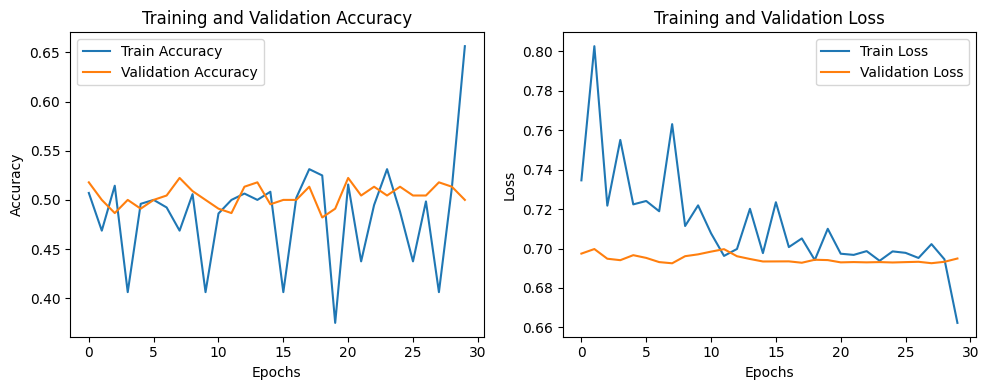

In [12]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [13]:
# Final evaluation on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

15/15 - 27s - 2s/step - accuracy: 0.5272 - loss: 0.6917

Test accuracy: 0.5271966457366943


15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step


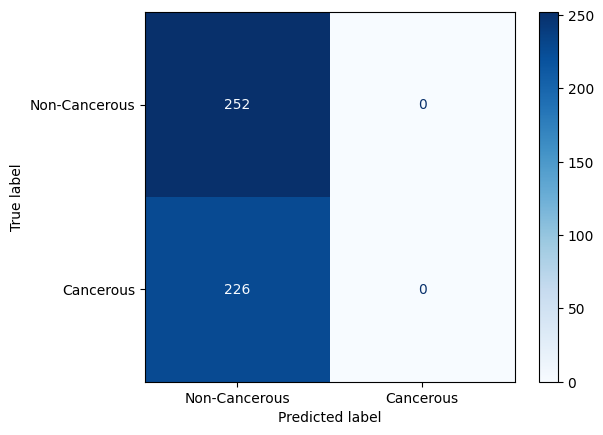

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary class labels
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.show()